# Tohoku tsunami inversion
## 5. Inversion using discrete adjoint with 130 basis functions

Let's extend the methodology from notebook 4 to a basis of dimension 130.

In [1]:
%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
from time import clock

In [3]:
from thetis import *
from firedrake_adjoint import *
from firedrake.adjoint.blocks import GenericSolveBlock

In [4]:
from adapt_utils.case_studies.tohoku.options import TohokuOptions
from adapt_utils.norms import total_variation
from adapt_utils.misc import gaussian, ellipse, rotation_matrix

_[Misc plotting functions]_

In [5]:
def plot_field(field, figure=None, axes=None, height=5, **kwargs):
    CG1 = field.ufl_element().degree() == 1 and field.ufl_element().family() == 'Lagrange'
    fs_constructor = FunctionSpace if len(field.function_space().shape) == 0 else VectorFunctionSpace
    out = field if CG1 else interpolate(field, fs_constructor(field.function_space().mesh(), "CG", 1))
    
    if figure is None and axes is None:
        figure, axes = plt.subplots(figsize=(height*1.2, height))
    if axes is None:
        axes = plt.gca()
    figure.colorbar(tricontourf(out, levels=50, axes=axes, cmap='coolwarm', **kwargs), ax=axes);
    axes.axis(False);
    axes.set_title(field.dat.name);
    return axes

In [6]:
def plot_fields(*fields, height=5):
    nfields = len(fields)
    fig, axes = plt.subplots(ncols=nfields, figsize=(height*nfields*1.2, height))
    for i, field in enumerate(fields):
        try:
            plot_field(field, fig, axes[i])
        except AttributeError:
            plot_mesh(field, fig, axes[i])
    return axes

In [7]:
level = 0
# level = 1
# level = 2

op = TohokuOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    try:
        op.default_mesh.coordinates.at(op.gauges[gauge]['coords'])
    except PointNotInDomainError:
        op.gauges.pop(gauge)  # Some gauges aren't within the domain
        
mesh = op.default_mesh
R = FunctionSpace(mesh, "R", 0)

boundary_conditions = {
    100: ['freeslip', 'dirichlet'],
    200: ['freeslip'],
    300: ['freeslip'],
}

### Forward model

As before, consider the shallow water equations linearised about lake at rest:

$$
    \frac{\partial\mathbf u}{\partial t}+g\nabla\eta+f\widehat{\mathbf z}\times\mathbf u=\boldsymbol0,\qquad
    \frac{\partial\eta}{\partial t}+\nabla\cdot(b\mathbf u)=0,\qquad
    \text{in}\quad(0,T]\times\Omega,
$$

equipped with boundary conditions

$$
    \mathbf u\cdot\widehat{\mathbf n}|_{\Gamma_{\mathrm{freeslip}}}\equiv0,\qquad
    \eta|_{\Gamma_D}\equiv0.
$$

Assume zero initial velocity and expand the initial surface over a radial basis:

$$
    \mathbf u|_{t=0}\equiv\boldsymbol0,\qquad
    \eta|_{t=0}=\sum_{k=1}^N m_kg_k,
$$

where $m_k$ are (constant in space) control parameters and $g_k$ are Gaussians.

In [8]:
basis_region_centre = np.array([0.7e+06, 4.2e+06])
extent_x = 240.0e+03
extent_y = 560.0e+03
Nx = 10
Ny = 13
angle = -pi/12

In [9]:
N = Nx*Ny
basis_centres = []
Rtheta = rotation_matrix(angle)
for i in range(Nx):
    basis_centre_x = i*extent_x/(Nx-1) - 0.5*extent_x
    for j in range(Ny):
        basis_centre_y = j*extent_y/(Ny-1) - 0.5*extent_y
        basis_centres.append(tuple(basis_region_centre + np.dot(Rtheta, np.array([basis_centre_x, basis_centre_y]))))

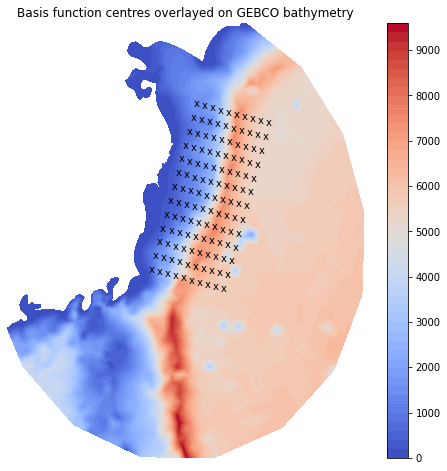

In [10]:
P1 = FunctionSpace(mesh, "CG", 1)
b = Function(P1, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(P1))

fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(tricontourf(b, axes=axes, cmap='coolwarm', levels=50), ax=axes)
axes.axis('off')
for loc in basis_centres:
    axes.annotate('x', xy=loc)
axes.set_title("Basis function centres overlayed on GEBCO bathymetry");

Setup for the initial condition

In [11]:
def get_basis_functions(fs, skew=(24e+03, 48e+03)):
    """
    Define an array of radial basis functions, each of which is a skewed Gaussian. The array is rotated
    about its centre by the (global) `angle` parameter.
    
    :arg fs: the mixed function space in which the initial condition will live.
    :kwarg skew: a tuple describing the extents to which the basis functions are skewed in the rotated axes.
    """
    basis_functions = []
    for loc in basis_centres:
        basis_function = Function(fs)
        psi, phi = basis_function.split()
        phi.interpolate(gaussian([loc + skew, ], fs.mesh(), rotation=angle))
        basis_functions.append(basis_function)
    return basis_functions

In [12]:
def set_basis_coefficients(values):
    """
    Create an array of `Function`s which live in the R-space (of spatial constants) and initialise
    with the provided `values`.
    """
    basis_coefficients = [Function(R) for k in range(N)]
    if isinstance(values, (float, int)):
        values = [values for k in range(N)]
    assert len(values) == N
    for k, val in enumerate(values):
        basis_coefficients[k].assign(val)
    return basis_coefficients

In [13]:
def set_initial_condition(coeffs, fs):
    """
    Construct the propsed initial condition from the basis functions and the proposed coefficients.
    
    Note that if we try and sum all 130 components at once then we get a `maximum recursion depth
    exceeded` error in UFL due to the nested sum. To get around this we just do the sum in two parts.
    
    :arg coeffs: the proposed basis coefficients, expressed as a list.
    :arg fs: the mixed function space in which the initial condition will live.
    """
    basis_functions = get_basis_functions(fs)
    ic = Function(fs)
    tmp = Function(fs)
    ic.project(sum(m*phi for m, phi in zip(coeffs[:N//2], basis_functions[:N//2])))
    tmp.project(sum(m*phi for m, phi in zip(coeffs[N//2:], basis_functions[N//2:])))
    ic.assign(ic + tmp)
    return ic

In [14]:
def get_fields(fs):
    """
    Define fields associated with the physical model, as well as the gravitational acceleration constant.
      
    :arg fs: the mixed function space used to solve the forward problem. The bathymetry and the Coriolis
        parameter are taken to live in the associated elevation space.
    """
    elev_space = fs.sub(1)
    b = Function(elev_space, name="Bathymetry (from GEBCO)").assign(op.set_bathymetry(elev_space))
    f = Function(elev_space, name="Coriolis parameter").assign(op.set_coriolis(elev_space))
    g = Constant(op.g)
    return b, f, g

### Quantity of Interest

Again, we have the QoI

$$
J(\mathbf u,\eta)=\frac12\sum_{g\in\mathcal G}\int_0^T\int_\Omega\mathbb1_g\big(\:\eta(x,t)-\eta_g(t)\:\big)^2\;\mathrm dx\;\mathrm dt,
$$

where $\mathbb1_g$ is an indicator function related to a sufficiently small neighbourhood of gauge $g$.

In [15]:
def sampled_timeseries(g, sample=1):
    time_prev = 0.0
    num_lines = sum(1 for line in open('resources/gauges/{:s}.dat'.format(g), 'r'))
    t, d, running = [], [], []
    with open('resources/gauges/{:s}.dat'.format(g), 'r') as f:
        for i in range(num_lines):
            time, dat = f.readline().split()
            time, dat = float(time), float(dat)
            if np.isnan(dat):
                continue
            running.append(dat)
            if i % sample == 0 and i > 0:
                t.append(0.5*(time + time_prev))
                d.append(np.mean(running))
                running = 0
                time_prev = time
                running = []
                
    interp = scipy.interpolate.interp1d(t, d, bounds_error=False, fill_value='extrapolate')
    init = interp(0.0)
    
    def shifted(tau):
        return interp(tau) - init
    
    return shifted

In [74]:
def solve_forward(m, store_timeseries=False, ext=''):
    """
    Solve the linearised shallow water equations for an array of control parameters, `m`.
    
    :arg m: the array of control parameters, which should have dimension `N`.
    """
    print("FORWARD SOLVE")
    if isinstance(m, Function):
        m = [m, ]
    
    # --- Setup function spaces
    
    fs = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    P0 = FunctionSpace(mesh, "DG", 0)
    
    # -- Setup fields
    
    b, f, g = get_fields(fs)
    
    # --- Setup PDE
    
    dtc = Constant(op.dt)
    
    u, eta = TrialFunctions(fs)
    z, zeta = TestFunctions(fs)

    q_ = Function(fs)
    u_, eta_ = q_.split()

    a = inner(z, u)*dx + inner(zeta, eta)*dx
    L = inner(z, u_)*dx + inner(zeta, eta_)*dx
    
    n = FacetNormal(mesh)

    def G(uv, elev):
        F = g*inner(z, grad(elev))*dx
        F += f*inner(z, as_vector((-uv[1], uv[0])))*dx
        F += -inner(grad(zeta), b*uv)*dx
        for tag in boundary_conditions:
            if 'freeslip' not in boundary_conditions[tag]:
                F += inner(zeta*n, b*uv)*ds(tag)
        return F

    a += 0.5*dtc*G(u, eta)
    L += -0.5*dtc*G(u_, eta_)

    q = Function(fs)
    u, eta = q.split()

    bcs = []
    for tag in boundary_conditions:
        if 'dirichlet' in boundary_conditions[tag]:
            bcs.append(DirichletBC(fs.sub(1), 0, tag))

    params = {
        "snes_type": "ksponly",
        "ksp_type": "gmres",
        "pc_type": "fieldsplit",
        "pc_fieldsplit_type": "multiplicative",
    }

    problem = LinearVariationalProblem(a, L, q, bcs=bcs)
    solver = LinearVariationalSolver(problem, solver_parameters=params)
    
    # --- Setup initial condition / control
    
    basis_functions = get_basis_functions(fs)
    try:
        assert len(basis_functions) == N
        assert len(m) == N
    except AssertionError:
        msg = "Number of basis functions and number of basis coefficients do not match ({:d} vs {:d})"
        raise ValueError(msg.format(len(basis_functions), len(m)))
        
    q_.assign(set_initial_condition(m, fs))
    
    # --- Setup QoI
    
    radius = 20.0e+03*pow(0.5, level)  # The finer the mesh, the more precise the indicator region
    for gauge in op.gauges:
        op.gauges[gauge]['indicator'] = interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,), ], mesh), P0)
        op.gauges[gauge]['interpolator'] = sampled_timeseries(gauge, sample=1 if gauge[0] == '8' else 60)
        if store_timeseries:
            op.gauges[gauge]['timeseries'+ext] = []
            op.gauges[gauge]['diff'+ext] = []
            op.gauges[gauge]['timeseries_smooth'+ext] = []
            op.gauges[gauge]['diff_smooth'+ext] = []
            op.gauges[gauge]['data'] = []
            op.gauges[gauge]['init'+ext] = None
            op.gauges[gauge]['area'] = assemble(op.gauges[gauge]['indicator']*dx, annotate=False)
    times = []
        
    op.end_time = 1440.0

    # --- Time integrate
    
    t = 0.0
    iteration = 0
    J = 0
    eta_obs = Constant(0.0)
    weight = Constant(1.0)
    tic = clock()
    msg = "    simulation time {:4.1f} minutes    wallclock time {:4.1f} seconds"
    while t < op.end_time:
        times.append(t)
        if iteration % 48 == 0:
            toc = clock() - tic
            print(msg.format(t/60, toc))
            tic = clock()

        # Solve forward equation at current timestep
        solver.solve()

        # Time integrate QoI
        weight.assign(0.5 if np.allclose(t, 0.0) else 1.0)
        u, eta = q.split()
        for gauge in op.gauges:
            
            # Interpolate observations
            obs = float(op.gauges[gauge]['interpolator'](t))
            eta_obs.assign(obs)
            
            if store_timeseries:
                op.gauges[gauge]['data'].append(obs)
                
                # Point evaluation at gauges
                eta_discrete = eta.at(op.gauges[gauge]["coords"])
                if iteration == 0:
                    op.gauges[gauge]['init'+ext] = eta_discrete
                op.gauges[gauge]['timeseries'+ext].append(eta_discrete - op.gauges[gauge]['init'+ext])
                
                # Discrete form of error
                diff = 0.5*(eta_discrete - eta_obs.dat.data[0])**2
                op.gauges[gauge]['diff'+ext].append(diff)

            # Continuous form of error
            I = op.gauges[gauge]['indicator']
            eta_shift = eta - op.gauges[gauge]['init'+ext]
            diff = 0.5*I*(eta_shift - eta_obs)**2
            J += assemble(weight*dtc*diff*dx)
            if store_timeseries:
                A = op.gauges[gauge]['area']
                op.gauges[gauge]['diff_smooth'+ext].append(assemble(diff*dx, annotate=False)/A)
                op.gauges[gauge]['timeseries_smooth'+ext].append(assemble(I*eta_shift*dx, annotate=False)/A)

        # Increment
        q_.assign(q)
        t += op.dt
        iteration += 1

    assert np.allclose(t, op.end_time), print("mismatching end time ({:.2f} vs {:.2f})".format(t, op.end_time))
    toc = clock() - tic
    print(msg.format(t/60, toc))
    print("    Quantity of interest = {:.8e}".format(J))
    return J, q

In [75]:
def reduced_functional(m, **kwargs):
    J, q = solve_forward(m)
    try:
        controls = [Control(mi) for mi in m]
    except IndexError:
        controls = Control(m)
    return ReducedFunctional(J, controls, **kwargs)

Set an initial guess

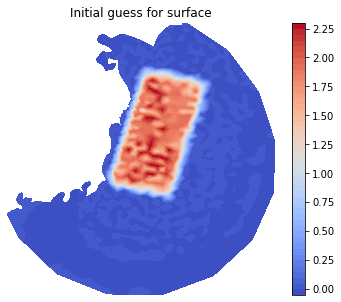

In [76]:
tape = get_working_tape()
tape.clear_tape()
basis_coefficients = set_basis_coefficients(1.0)
with stop_annotating():
    TaylorHood = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    initial_guess = set_initial_condition(basis_coefficients, TaylorHood)
    initial_guess_u, initial_guess_eta = initial_guess.split()
    initial_guess_eta.dat.name = "Initial guess for surface"
    plot_field(initial_guess_eta);

Let's take a look at the forward solution.

FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 59.2 seconds
    simulation time  8.0 minutes    wallclock time 41.0 seconds
    simulation time 12.0 minutes    wallclock time 40.1 seconds
    simulation time 16.0 minutes    wallclock time 40.3 seconds
    simulation time 20.0 minutes    wallclock time 40.9 seconds
    simulation time 24.0 minutes    wallclock time 40.6 seconds
    Quantity of interest = 1.55000469e+13


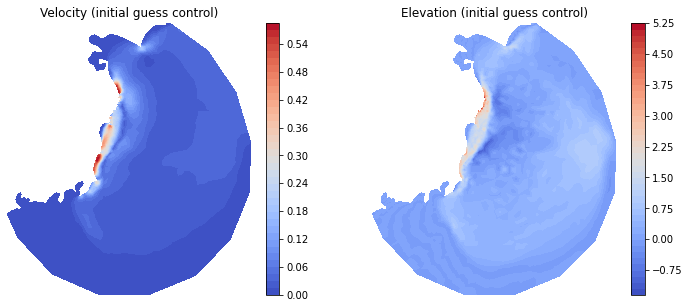

In [77]:
J, q = solve_forward(basis_coefficients, store_timeseries=True)
u, eta = q.split()
u.dat.name = "Velocity (initial guess control)"
eta.dat.name = "Elevation (initial guess control)"
plot_fields(u, eta);

In [24]:
controls = [Control(m) for m in basis_coefficients]
g = compute_gradient(J, controls)

Let's take a look at the adjoint solution.

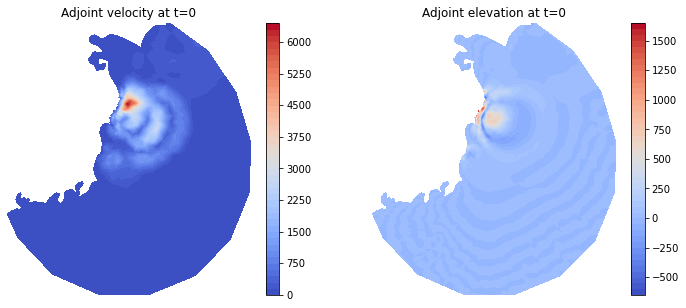

In [25]:
blocks = tape.get_blocks()
solve_blocks = [block for block in blocks if isinstance(block, GenericSolveBlock)]
u_star, eta_star = solve_blocks[0].adj_sol.split()
u_star.dat.name = "Adjoint velocity at t=0"
eta_star.dat.name = "Adjoint elevation at t=0"
plot_fields(u_star, eta_star);

## Inversion for 130 basis function coefficients

Now that we have functions for solving the forward problem and computing the gradient, we can apply a quasi-Newton optimisation method such as BFGS to optimise the control parameter.

In [26]:
def derivative_cb_post(j, dj, m):
    gradient_values = np.array([abs(g.dat.data[0]) for g in dj])
    print("functional  {:.8e}  maximum gradient component {:.8e}".format(j, gradient_values.max()))

opt_parameters = {
    'maxiter': 10,
    'gtol': 1.0,
}

tape = get_working_tape()
tape.clear_tape()

# Set initial guesses for controls
m = set_basis_coefficients(1.0)

# Evaluate the reduced functional
J = reduced_functional(m, derivative_cb_post=derivative_cb_post)

# Call the optimisation routine
m_opt = minimize(J, method='BFGS', options=opt_parameters)

FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 15.1 seconds
    simulation time  8.0 minutes    wallclock time 16.3 seconds
    simulation time 12.0 minutes    wallclock time 16.7 seconds
    simulation time 16.0 minutes    wallclock time 15.7 seconds
    simulation time 20.0 minutes    wallclock time 15.9 seconds
    simulation time 24.0 minutes    wallclock time 16.7 seconds
    Quantity of interest = 1.18703539e+13
functional  1.18703539e+13  maximum gradient component 1.28094482e+12
functional  9.40245115e+12  maximum gradient component 9.20423252e+11
functional  8.00677517e+12  maximum gradient component 1.11532159e+12
functional  1.41432252e+13  maximum gradient component 1.17402123e+12
functional  7.78489855e+12  maximum gradient component 1.12456093e+12
functional  7.69744442e+12  maximum gradient component 1.14400234e+12
functional  7.62107426e+12  maximum gradient component 1.13296122e+12
      

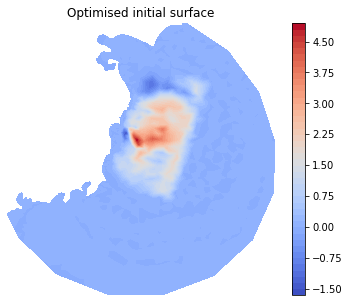

In [27]:
with stop_annotating():
    TaylorHood = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    ic_opt = set_initial_condition(m_opt, TaylorHood)
    ic_opt_u, ic_opt_eta = ic_opt.split()
    ic_opt_eta.dat.name = "Optimised initial surface"
    plot_field(ic_opt_eta);

Unsurprisingly, we didn't reach convergence in 5 iterations so let's carry on from where we left off.

In [28]:
m_opt_saved = [m_opt_i.dat.data[0] for m_opt_i in m_opt]

In [29]:
tape = get_working_tape()
tape.clear_tape()

# Set initial guesses for controls
m = set_basis_coefficients(m_opt_saved)

# Evaluate the reduced functional
J = reduced_functional(m, derivative_cb_post=derivative_cb_post)

# Call the optimisation routine
m_opt = minimize(J, method='BFGS', options=opt_parameters)

FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 15.7 seconds
    simulation time  8.0 minutes    wallclock time 15.6 seconds
    simulation time 12.0 minutes    wallclock time 16.1 seconds
    simulation time 16.0 minutes    wallclock time 17.1 seconds
    simulation time 20.0 minutes    wallclock time 16.2 seconds
    simulation time 24.0 minutes    wallclock time 16.2 seconds
    Quantity of interest = 7.62107427e+12
functional  7.62107426e+12  maximum gradient component 1.13296122e+12
functional  5.59905719e+12  maximum gradient component 7.38913055e+11
functional  4.05659674e+13  maximum gradient component 1.33204852e+12
functional  5.49225598e+12  maximum gradient component 7.44137262e+11
functional  5.68926705e+12  maximum gradient component 7.01608256e+11
functional  5.46406512e+12  maximum gradient component 7.33022600e+11
functional  5.44107615e+12  maximum gradient component 7.41624466e+11
functi

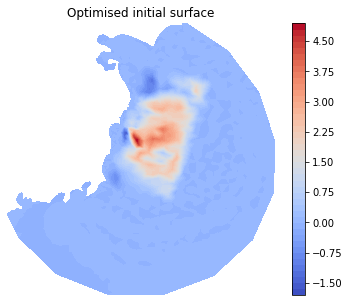

In [30]:
with stop_annotating():
    TaylorHood = VectorFunctionSpace(mesh, "CG", 2)*FunctionSpace(mesh, "CG", 1)
    ic_opt = set_initial_condition(m_opt, TaylorHood)
    ic_opt_u, ic_opt_eta = ic_opt.split()
    ic_opt_eta.dat.name = "Optimised initial surface"
    plot_field(ic_opt_eta);

In [31]:
print("m_opt_saved = [")
for mi in m_opt:
    print("    {:.8e},".format(mi.dat.data[0]))
print("]")

m_opt_saved = [
    -6.08167817e-01,
    -3.33306204e-01,
    5.34018118e-01,
    1.42869928e-01,
    -1.25277760e-01,
    -1.91441437e+00,
    8.30032177e-01,
    7.90137442e-01,
    7.27195574e-02,
    2.20609748e-01,
    -4.36051851e-01,
    -1.06833403e-01,
    -5.50617858e-01,
    -2.73267962e-01,
    1.74693923e-01,
    4.58712863e-01,
    9.52059844e-01,
    -1.52861885e-01,
    3.43670155e+00,
    2.76182147e-01,
    1.07835313e-01,
    7.39383638e-01,
    1.01428410e+00,
    -6.29986993e-01,
    -6.51326465e-01,
    -5.58771163e-01,
    6.81650002e-02,
    1.92612761e-01,
    4.02572950e-01,
    1.78107179e+00,
    1.38615950e+00,
    2.36309541e+00,
    1.44576120e+00,
    5.22506685e-01,
    1.44451654e-01,
    1.27998542e+00,
    -9.42139822e-02,
    -4.86225871e-01,
    2.76782607e-01,
    6.98563379e-02,
    2.15849399e-01,
    7.85292344e-01,
    1.31714364e+00,
    1.34959982e+00,
    1.11191822e+00,
    1.25282076e+00,
    1.18788758e+00,
    9.36434724e-01,
    1.7917

FORWARD SOLVE
    simulation time  0.0 minutes    wallclock time  0.0 seconds
    simulation time  4.0 minutes    wallclock time 58.6 seconds
    simulation time  8.0 minutes    wallclock time 39.1 seconds
    simulation time 12.0 minutes    wallclock time 41.4 seconds
    simulation time 16.0 minutes    wallclock time 40.1 seconds
    simulation time 20.0 minutes    wallclock time 39.5 seconds
    simulation time 24.0 minutes    wallclock time 40.7 seconds
    Quantity of interest = 7.65519715e+12


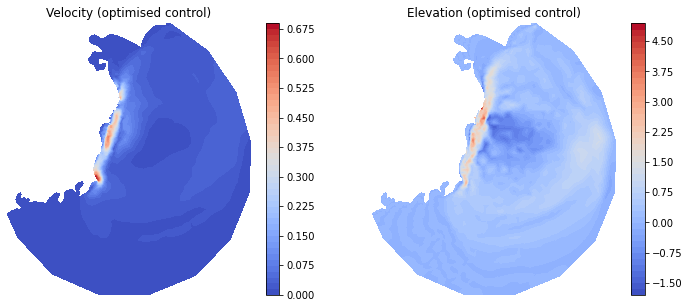

In [80]:
J, q_opt = solve_forward(m_opt, store_timeseries=True, ext='_opt')
u_opt, eta_opt = q_opt.split()
u_opt.dat.name = "Velocity (optimised control)"
eta_opt.dat.name = "Elevation (optimised control)"
plot_fields(u_opt, eta_opt);

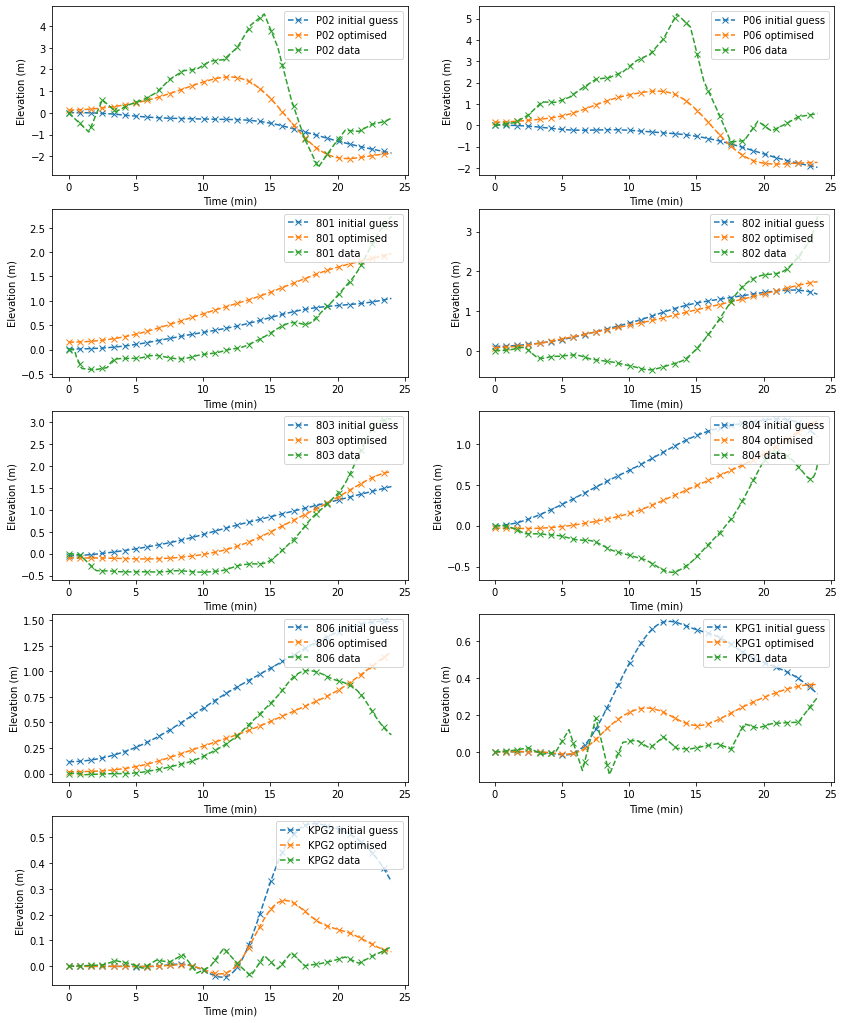

In [85]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
    ax.plot(times/60, op.gauges[gauge]['timeseries_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['timeseries_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['data'], '--x', label=gauge + ' data', markevery=10)
    ax.legend(loc='upper right')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Elevation (m)')
axes[4, 1].axis('off');

In [82]:
msg = "total variation for gauge {:s}: before {:.4e}  after {:.4e} reduction  {:.1f}%"

print("Continuous")
for gauge in op.gauges:
    tv = total_variation(op.gauges[gauge]['diff_smooth'])
    tv_opt = total_variation(op.gauges[gauge]['diff_smooth_opt'])
    print(msg.format(gauge, tv, tv_opt, 100*(1-tv_opt/tv)))
    
print("\nDiscrete")
for gauge in op.gauges:
    tv = total_variation(op.gauges[gauge]['diff'])
    tv_opt = total_variation(op.gauges[gauge]['diff_opt'])
    print(msg.format(gauge, tv, tv_opt, 100*(1-tv_opt/tv)))

Continuous
total variation for gauge P02: before 2.9313e+01  after 1.6839e+01 reduction  42.6%
total variation for gauge P06: before 3.5368e+01  after 1.8139e+01 reduction  48.7%
total variation for gauge 801: before 1.8437e+00  after 1.7461e+00 reduction  5.3%
total variation for gauge 802: before 3.8411e+00  after 2.9556e+00 reduction  23.1%
total variation for gauge 803: before 2.2874e+00  after 1.2406e+00 reduction  45.8%
total variation for gauge 804: before 2.5879e+00  after 1.2324e+00 reduction  52.4%
total variation for gauge 806: before 9.7713e-01  after 5.1555e-01 reduction  47.2%
total variation for gauge KPG1: before 5.4311e-01  after 1.9484e-01 reduction  64.1%
total variation for gauge KPG2: before 2.6907e-01  after 9.2799e-02 reduction  65.5%

Discrete
total variation for gauge P02: before 2.8306e+01  after 1.0047e+01 reduction  64.5%
total variation for gauge P06: before 1.9102e+01  after 1.0715e+01 reduction  43.9%
total variation for gauge 801: before 2.3166e+00  afte

We can also compare the instantaneous errors in the free surface approximation over the time period.

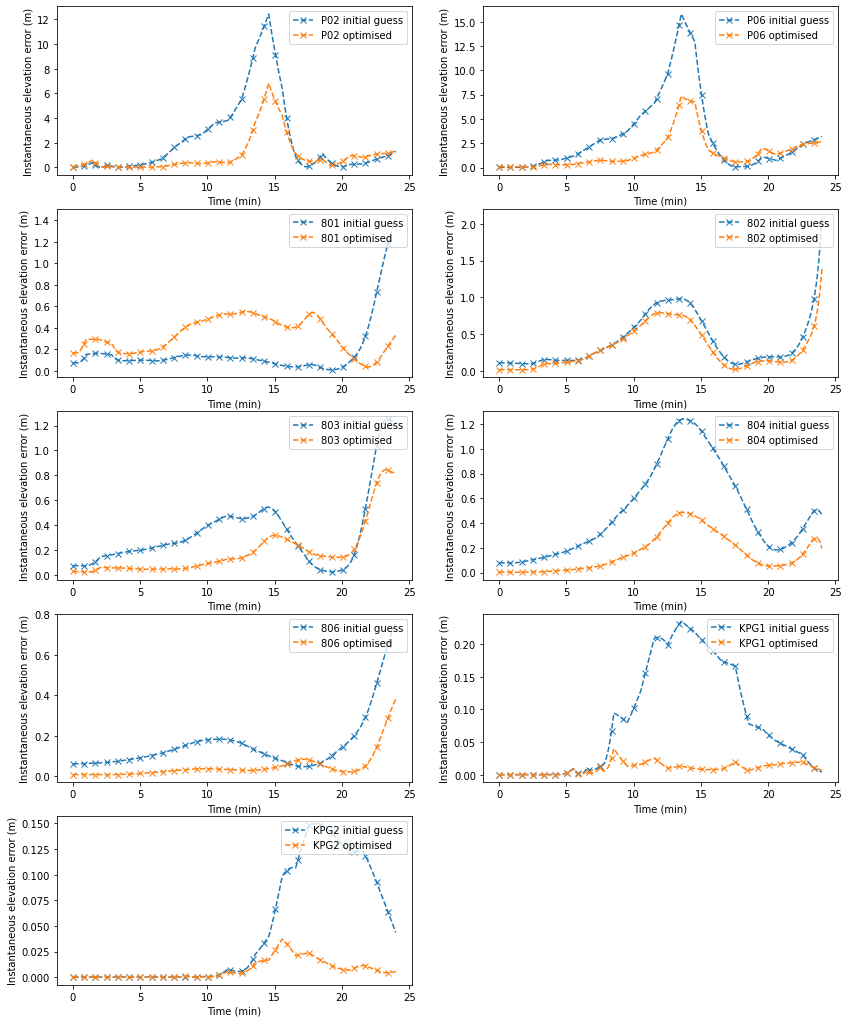

In [86]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 2*len(op.gauges)))

times = np.linspace(0, op.end_time, int(op.end_time/op.dt))
for i, gauge in enumerate(op.gauges):
    ax = axes[i//2, i%2]
    ax.plot(times/60, op.gauges[gauge]['diff_smooth'], '--x', label=gauge + ' initial guess', markevery=10)
    ax.plot(times/60, op.gauges[gauge]['diff_smooth_opt'], '--x', label=gauge + ' optimised', markevery=10)
    ax.legend(loc='upper right')
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Instantaneous elevation error (m)')
axes[4, 1].axis('off');

# TODO: Pass the approximate inverse Hessian to the restarted optimisation routine (otherwise it starts again from the identity)

    H = None

    rf_np = <ReducedFunctional>
    m = [p.data() for p in rf_np.controls]
    m_global = rf_np.obj_to_array(m)
    J = rf_np.__call__
    dJ = lambda m: rf_np.derivative(m, forget=False, project=False)
    kwargs = {
        'options': opt_parameters,
        'jac': dJ,
        'H': H,
    }
    res = scipy.optimize.minimize(J, m_global, method='BFGS', **kwargs)
    rf_np.set_controls(np.array(res['x']))
    m = [p.data() for p in rf_np.controls]
    
    H = res.<?????>